In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os
from scipy import signal

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

with open("python/movement_methods.py", "r") as file:
    exec(file.read())

with open("python/plot_all_events.py", "r") as file:
    exec(file.read())

# Rest detectiong using lower 80th percentile cutoff

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[1]
sample

SID              W1_C2
AnimalID            W1
CellName            C2
Region          S1_L23
Date        2019 12 09
Depth       265.898093
Count              270
Location         W1/C2
Cortex              S1
Layer              L23
Name: 1, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/filter.pkl")
channels = data.ch_names

## Rest episodes in a single channel

In [4]:
sample_data = data.get_data()
channel_data = sample_data[3]
time = data.times

In [5]:
threshold = np.percentile(np.abs(sample_data), 85)

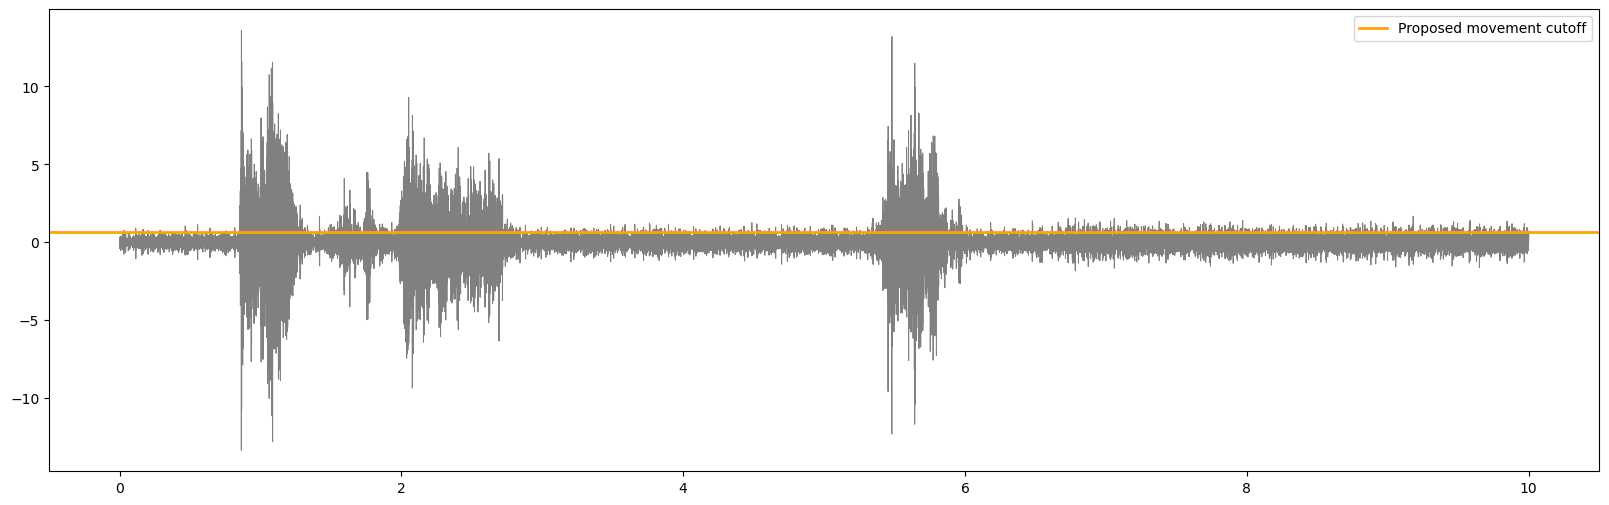

In [6]:
plt.figure(figsize = (20, 6))
plt.plot(time, (channel_data - np.mean(channel_data)) / np.std(channel_data), c = "gray", linewidth = 0.75)
plt.axhline(y = threshold, color = "orange", linestyle = "-", linewidth = 2, label = "Proposed movement cutoff")
plt.legend()
plt.show()

In [7]:
signal_over_threshold = np.abs(channel_data) > threshold
change_indices = np.where(np.diff(signal_over_threshold))[0]

movement_data = pd.DataFrame({
    "EventStart": np.insert(change_indices + 1, 0, 0),
    "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
})

movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
movement_data = movement_data[movement_data["Movement"] == False]
movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])
movement_data = movement_data[movement_data["EventLength"] >= 2000]

movement_data = merge_close_events(movement_data, min_break = 50)

movement_data["Start"] = movement_data["EventStart"] / data.info["sfreq"]
movement_data["End"] = movement_data["EventEnd"] / data.info["sfreq"]
movement_data["Length"] = movement_data["EventLength"] / data.info["sfreq"]

In [8]:
movement_data

,EventStart,EventEnd,Movement,EventLength,Start,End,Length
0,0,2292,False,2292,0.00000,0.1146,0.11460
1,3339,9318,False,5979,0.16695,0.4659,0.29895
2,12844,15100,False,2256,0.64220,0.7550,0.11280
3,60721,62776,False,2055,3.03605,3.1388,0.10275


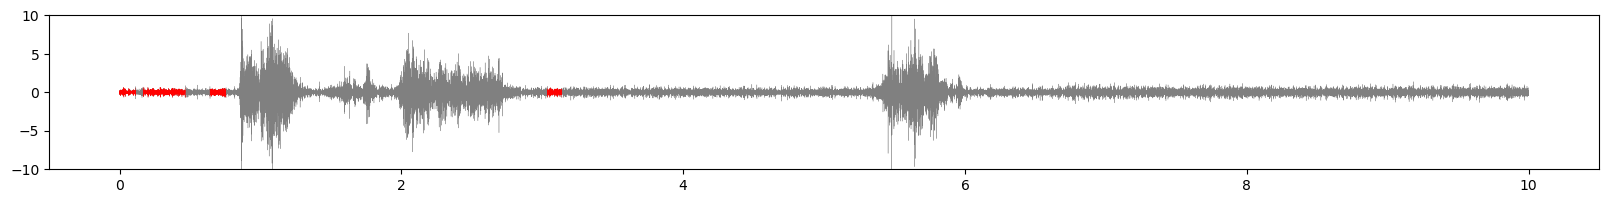

In [9]:
plt.figure(figsize = (20, 2))

x = data.times
y = channel_data

plt.plot(x, y, c = "gray", linewidth = 0.25)

for i, episode in movement_data.iterrows():
    x = data.times[episode["EventStart"]:episode["EventEnd"]]
    y = channel_data[episode["EventStart"]:episode["EventEnd"]]

    plt.plot(x, y, c = "red", linewidth = 0.25)

plt.ylim(-10, 10)
plt.show()

## Rest in all channels

In [10]:
def detect_rest_episodes(signal, threshold, sfreq, min_break, min_length):
    import numpy as np
    import pandas as pd

    signal_over_threshold = np.abs(signal) > threshold
    change_indices = np.where(np.diff(signal_over_threshold))[0]

    movement_data = pd.DataFrame({
        "EventStart": np.insert(change_indices + 1, 0, 0),
        "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
    })

    movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
    movement_data = movement_data[ movement_data["Movement"] == False ]
    movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])
    movement_data = movement_data[movement_data["EventLength"] >= min_length]

    movement_data = merge_close_events(movement_data, min_break = min_break)

    movement_data["Start"] = movement_data["EventStart"] / sfreq
    movement_data["End"] = movement_data["EventEnd"] / sfreq
    movement_data["Length"] = movement_data["EventLength"] / sfreq

    return movement_data

In [11]:
sample_data = data.get_data()
threshold = np.percentile(np.abs(sample_data), 85)

episodes = []

for i, _ in enumerate(data.ch_names):
    signal = sample_data[i]

    ch_episodes = detect_rest_episodes(signal = signal, threshold = threshold, sfreq = data.info["sfreq"],
                                       min_break = 50, min_length = 2000)
    ch_episodes["Channel"] = i
    episodes.append(ch_episodes)

episodes = pd.concat(episodes)
episodes = episodes.reset_index(drop = True)

In [12]:
movement = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/movement_episodes.csv")

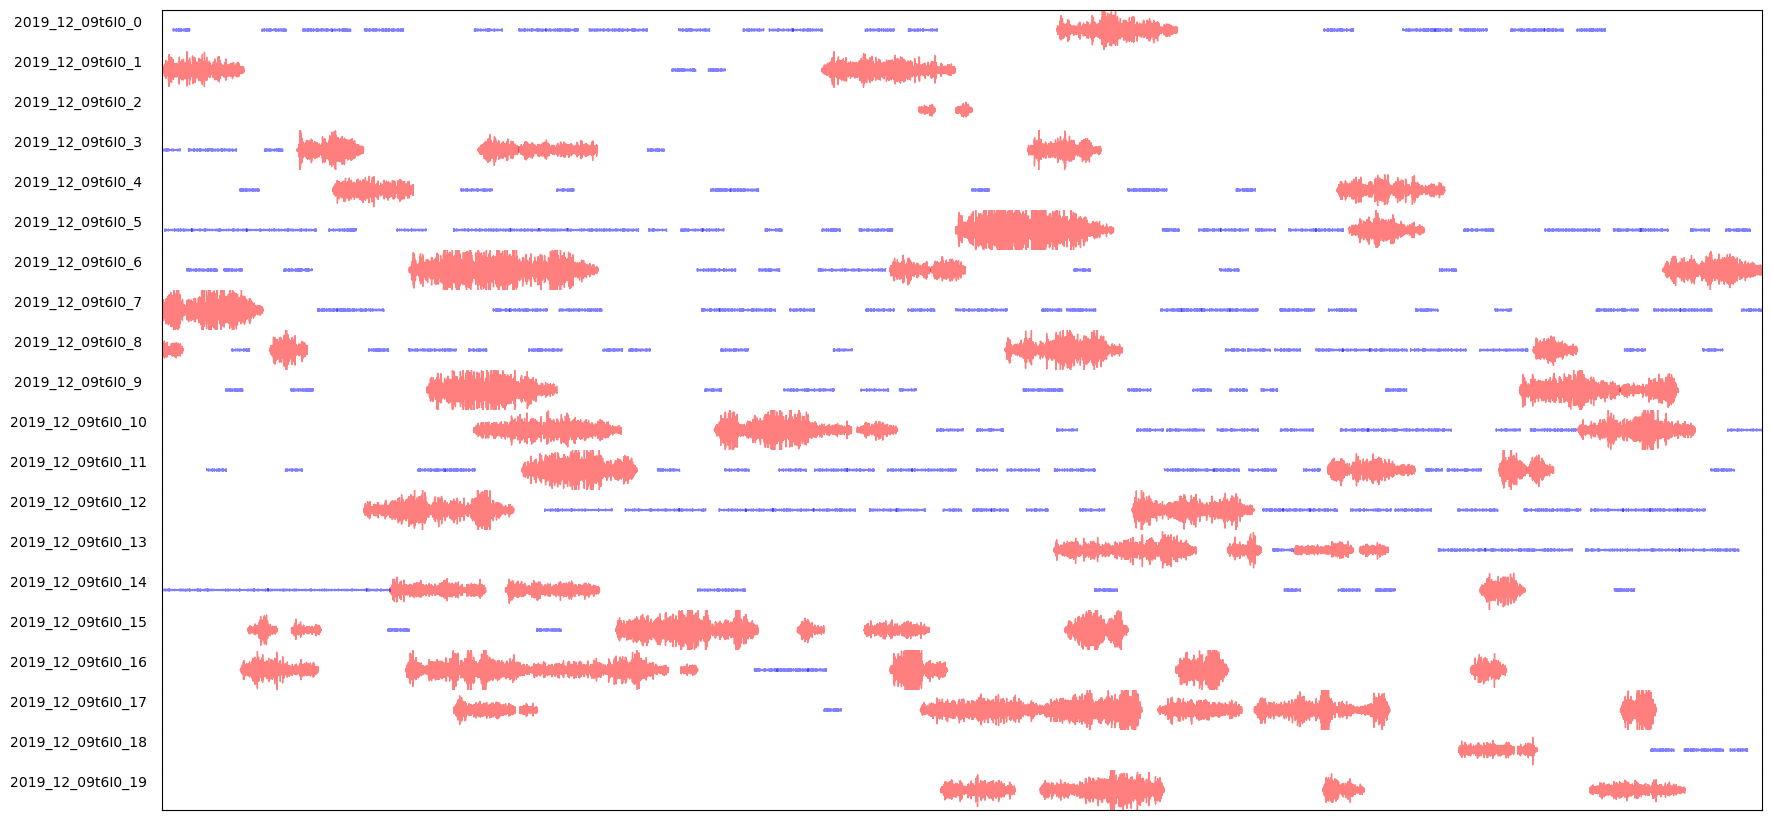

In [13]:
plot_all_events(data, channels = data.ch_names, movement = movement, no_movement = episodes, limit = [-10, 10],
                show_full = False, alpha = 0.5)